# Make things Ready

## Mount google-drive & Load dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#shared path to drive
SHARED_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

#direct path to drive
DIRECT_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

Mounted at /content/drive


In [2]:
import os

# Determine the data path based on the existence of shared or direct paths
root_path = SHARED_PATH if os.path.exists(SHARED_PATH) else DIRECT_PATH if os.path.exists(DIRECT_PATH) else None

DATA_PATH = ''
# Print the chosen path or an error message
if root_path:
    print(f"Using path: {root_path}")
    DATA_PATH = root_path + "/Proj1_CGC_Building_with_sides_classify"
    for filename in os.listdir(DATA_PATH):
        print(filename)
else:
    print("Neither shared nor direct path exists. Please check the paths.")


Using path: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours
validate_images
training_images
ALL_IMG_DATA
no_side_one_output_classify
ALL_IMG_DATA.csv
make_train-test-split_from_all_img_data.ipynb
expr2_resnet18_two_output_(sides classify).ipynb
RUN_THIS_all_in_1_changable_parameter_(2_output).ipynb


##  Setup Device & Random State

In [3]:
import torch
import random
import numpy as np

# Define device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# define the random seed
SEED = 2025


torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.Generator().manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)

cuda


## Load data(csv) & Train-Test Split

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display

# Load the CSV data into a DataFrame
df = pd.read_csv(DATA_PATH+"/ALL_IMG_DATA.csv")
display(df.head())
#  --- Derive ALL unique categories from the FULL DataFrame ---
BUILDING_CATEGORIES = sorted(df['class'].unique().tolist())
FACADE_CATEGORIES = sorted(df['subclass'].unique().tolist())

print("\nMaster Building Categories:", BUILDING_CATEGORIES)
print("Master Facade Categories:", FACADE_CATEGORIES)

,path,class,subclass
0,/ALL_IMG_DATA/gurudeb_front/gurudeb_005.jpeg,gurudeb,front
1,/ALL_IMG_DATA/gurudeb_front/gurudeb_004.jpeg,gurudeb,front
2,/ALL_IMG_DATA/gurudeb_front/frame_0210.jpg,gurudeb,front
3,/ALL_IMG_DATA/gurudeb_front/gurudeb_002.jpeg,gurudeb,front
4,/ALL_IMG_DATA/gurudeb_front/gurufront_00040.jpeg,gurudeb,front



Master Building Categories: ['admin', 'chemistry', 'gurudeb', 'heritage']
Master Facade Categories: ['front', 'left', 'right']


In [5]:
# Split the data into training and testing sets

# train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['class'])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['subclass'])
# this distrubutes better
print('------------ Training set subclass frequencies within each class ----------------')
print(train_df.groupby('class')['subclass'].value_counts().sort_index())
print('------------ Test set subclass frequencies within each class ----------------')
print(test_df.groupby('class')['subclass'].value_counts().sort_index())

------------ Training set subclass frequencies within each class ----------------
class      subclass
admin      front       27
           left        21
           right       25
chemistry  front       32
           left        28
           right       28
gurudeb    front       33
           left        22
           right       26
heritage   front       27
           left        26
Name: count, dtype: int64
------------ Test set subclass frequencies within each class ----------------
class      subclass
admin      front       7
           left        6
           right       7
chemistry  front       8
           left        7
           right       9
gurudeb    front       8
           left        5
           right       4
heritage   front       7
           left        6
Name: count, dtype: int64


## Define data transformations

In [6]:
import torchvision.transforms as transforms

mean=[0.485, 0.456, 0.406]
standev=[0.229, 0.224, 0.225]
px=256

train_transform = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomRotation(10),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomHorizontalFlip(), #!! it will change left right
    transforms.ColorJitter(),
    # transforms.RandomAffine(degrees=0),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

test_transform =  transforms.Compose([
    transforms.Resize((px, px)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

print(train_transform)

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Load dataset with Torch

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class MakeTorchDataset(Dataset):
    def __init__(self, dataframe, image_base_path=DATA_PATH,
    building_categories=BUILDING_CATEGORIES, facade_categories=FACADE_CATEGORIES,
    transform=None):
        self.dataframe = dataframe
        self.image_base_path = image_base_path
        self.transform = transform
        # Create mappings for class and subclass based on the *provided* category lists
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(building_categories)}
        self.subclass_to_idx = {sub_name: i for i, sub_name in enumerate(facade_categories)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_full_path = self.image_base_path+self.dataframe.iloc[idx]['path']
        # print(img_full_path)
        image = Image.open(img_full_path).convert('RGB')

        # Access labels by column name for clarity and robustness
        building_class_name = self.dataframe.iloc[idx]['class']
        facade_subclass_name = self.dataframe.iloc[idx]['subclass']

        # Convert string labels to integer indices using the pre-defined mappings
        building_class_label = self.class_to_idx[building_class_name]
        facade_subclass_label = self.subclass_to_idx[facade_subclass_name]

        if self.transform: image = self.transform(image) # apply transformation

        return image, building_class_label, facade_subclass_label

In [8]:
train_dataset = MakeTorchDataset(dataframe=train_df, transform=train_transform)
test_dataset = MakeTorchDataset(dataframe=test_df, transform=test_transform)

print("Building Categories:", train_dataset.class_to_idx)
print("Facade Categories:", train_dataset.subclass_to_idx)

train_dataset.__getitem__(0)

Building Categories: {'admin': 0, 'chemistry': 1, 'gurudeb': 2, 'heritage': 3}
Facade Categories: {'front': 0, 'left': 1, 'right': 2}


(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -0.3369, -0.0629,  0.0398],
          [-2.1179, -2.1179, -2.1179,  ..., -0.6623, -0.9877, -1.1760],
          [-2.1179, -2.1179, -2.1179,  ..., -0.5253, -0.2856, -0.1314],
          ...,
          [-2.1179, -2.1179, -2.1179,  ...,  0.8618,  0.8618,  0.9132],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -0.1275,  0.1877,  0.2927],
          [-2.0357, -2.0357, -2.0357,  ..., -0.4601, -0.7577, -0.9503],
          [-2.0357, -2.0357, -2.0357,  ..., -0.2850, -0.0574,  0.1001],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -0.1099, -0.1275, -0.1450],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -0.0267,  0.2871,  0.3916],
          [-1.8044, -1.8044,

## Class definition

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt


class BuildingWithFacadeClassifier:
    """
    A class for training, evaluating, and classifying images with a multi-head model
    using a custom dataset that directly provides two labels.
    """
    def __init__(self, model, optimizer, batch_size=16,
    building_categories=BUILDING_CATEGORIES, facade_categories=FACADE_CATEGORIES,
    building_loss_fn=nn.CrossEntropyLoss(), facade_loss_fn=nn.CrossEntropyLoss(),
    train_dataset=train_dataset, test_dataset=test_dataset, device=DEVICE):

        self.model = model.to(device)
        self.building_loss_fn = building_loss_fn
        self.facade_loss_fn = facade_loss_fn
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.building_categories = building_categories
        self.facade_categories = facade_categories
        self.device = device

        self.learning_rate = self.optimizer.param_groups[0]['lr']
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True) #, num_workers=2)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False) #, num_workers=2)


    ###############################################################################################
    # Train the model for a specified number of epochs...........................................
    def train(self, n_epochs=10, output_logging=True):
        # Store individual lists for plotting later if needed
        loss_graph_list, valid_loss_list = [], []
        building_accy_list, facade_accy_list = [], []

        print(f"Starting training with Learning Rate: {self.learning_rate}, Batch Size: {self.batch_size}, Epochs: {n_epochs}, Device: {self.device}----")

        for epoch in tqdm(range(n_epochs)):
            self.model.train() # set model to training mode each time
            training_loss = []

            for i_image, i_building_label, i_facade_label in self.train_loader:
                i_image = i_image.to(self.device)
                i_building_label = i_building_label.to(self.device)
                i_facade_label = i_facade_label.to(self.device)

                self.optimizer.zero_grad()
                output_building, output_facade = self.model(i_image)

                # Calculate loss for each head
                loss_building = self.building_loss_fn(output_building, i_building_label)
                # Ensure retain_graph=True if building_loss_fn's backward pass needs to keep graph for facade_loss_fn's backward
                # loss_building.backward()
                loss_building.backward(retain_graph=True) # Need retain_graph=True
                # If they are independent, or if you sum before backward, it might not be needed.
                # A common pattern is to sum losses and then backward once.

                loss_facade = self.facade_loss_fn(output_facade, i_facade_label)
                loss_facade.backward() # No retain_graph=True needed here

                # Combine losses (e.g., simple average or weighted average)
                # Summing before backward is generally more efficient than two separate backward calls with retain_graph
                total_loss = (loss_building + loss_facade) / 2
                # total_loss.backward()

                self.optimizer.step()

                training_loss.append(total_loss.item()) # Use total_loss here

            mean_training_loss = np.mean(training_loss)
            loss_graph_list.append(mean_training_loss)

            # Call evaluate and get both accuracies and validation loss
            building_accy, facade_accy, current_valid_loss = self.evaluate(output_logging=False) # Set output_logging to False

            valid_loss_list.append(current_valid_loss)
            building_accy_list.append(building_accy)
            facade_accy_list.append(facade_accy)

            if output_logging:
                print(f" Training loss: {mean_training_loss:.4f} --Validation Loss: {current_valid_loss:.4f} --Building Accuracy: {building_accy:.2f}% --Facade Accuracy: {facade_accy:.2f}%")

        print("Training done.....................")
        # return detailed logs to plot them later
        return {"train_loss": loss_graph_list,"val_loss": valid_loss_list,
                "building_accy": building_accy_list,"facade_accy": facade_accy_list}


    ###############################################################################################
    # Evaluate the model on the test set (ENHANCED for both tasks)..............................
    def evaluate(self, output_logging=True, disp_confusion_matrix=False):
        self.model.eval() # set model to evaluation mode
        # Lists to store actual and predicted labels for confusion matrices
        actual_building_labels = []
        predicted_building_labels = []
        actual_facade_labels = []
        predicted_facade_labels = []
        validation_loss = []

        with torch.no_grad():
            for i_image, i_building_label, i_facade_label in self.test_loader:
                i_image = i_image.to(self.device)
                i_building_label = i_building_label.to(self.device)
                i_facade_label = i_facade_label.to(self.device)

                output_building, output_facade = self.model(i_image)

                loss_building = self.building_loss_fn(output_building, i_building_label)
                loss_facade = self.facade_loss_fn(output_facade, i_facade_label)
                total_loss = (loss_building + loss_facade) / 2
                validation_loss.append(total_loss.item())

                # Get predictions for building task
                _, predicted_building = torch.max(output_building.data, 1)
                actual_building_labels.extend(i_building_label.cpu().numpy())
                predicted_building_labels.extend(predicted_building.cpu().numpy())

                # Get predictions for facade task
                _, predicted_facade = torch.max(output_facade.data, 1)
                actual_facade_labels.extend(i_facade_label.cpu().numpy())
                predicted_facade_labels.extend(predicted_facade.cpu().numpy())

        # Calculate accuracies for each task
        building_accuracy = accuracy_score(actual_building_labels, predicted_building_labels)*100.0
        facade_accuracy = accuracy_score(actual_facade_labels, predicted_facade_labels)*100.0

        average_validation_loss = np.mean(validation_loss)

        if output_logging:
            print(f' --Validation Loss: {average_validation_loss:.4f}', end='')
            print(f'  --Building Accuracy: {building_accuracy:.2f}%', end='')
            print(f'  --Facade Accuracy: {facade_accuracy:.2f}%')

        if disp_confusion_matrix:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=80)
            # Confusion Matrix for Building Classification on the first subplot (ax1)
            ConfusionMatrixDisplay(
                confusion_matrix=confusion_matrix(actual_building_labels, predicted_building_labels),
                display_labels=[str(label) for label in self.building_categories] # Use defined building categories
            ).plot(cmap='Blues', ax=ax1) # Specify ax=ax1 to plot on the first subplot
            ax1.tick_params(axis='x', rotation=90) # Rotate x-axis labels for readability on ax1
            ax1.set_title("Building Classification")

            # Confusion Matrix for Facade Classification on the second subplot (ax2)
            ConfusionMatrixDisplay(
                confusion_matrix=confusion_matrix(actual_facade_labels, predicted_facade_labels),
                display_labels=[str(label) for label in self.facade_categories] # Use defined facade categories
            ).plot(cmap='Greens', ax=ax2) # Specify ax=ax2 to plot on the second subplot
            ax2.tick_params(axis='x', rotation=90) # Rotate x-axis labels for readability on ax2
            ax2.set_title("Facade Classification")

            plt.tight_layout() # Adjust layout to prevent overlap
            plt.show()

        # Return both accuracies and the average loss
        return building_accuracy, facade_accuracy, average_validation_loss


    ###############################################################################################
    # Classify a single image (No changes needed here)....................................
    def classify_image(self, img_path, img_transform):
        self.model.eval()

        try:
            image = Image.open(img_path).convert('RGB')
            plt.figure(dpi=50) # Set figure size
            plt.imshow(image) # Display the image
            plt.axis('off') # Turn off axis labels
            plt.show() # Show the plot
            image = img_transform(image).unsqueeze(0).to(self.device)
        except FileNotFoundError:
            print(f"Error: Image not found at {img_path}")
            return None, None, None, None
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            return None, None, None, None

        with torch.no_grad():
            output_building, output_facade = self.model(image)

            probabilities1 = torch.softmax(output_building, dim=1)
            probabilities2 = torch.softmax(output_facade, dim=1)

            print("Building Probabilities:", probabilities1)
            print("Facade Probabilities:", probabilities2)

            _, predicted_building_index = torch.max(probabilities1, 1)
            _, predicted_facade_index = torch.max(probabilities2, 1)

            predicted_building_class = self.building_categories[predicted_building_index.item()]
            predicted_facade_side = self.facade_categories[predicted_facade_index.item()]

            print(f"Predicted building class: {predicted_building_class} & the predicted facade side is: {predicted_facade_side}")

        return predicted_building_class, predicted_facade_side, probabilities1, probabilities2

In [10]:
print(train_dataset.class_to_idx)
print(len(train_dataset.class_to_idx))

{'admin': 0, 'chemistry': 1, 'gurudeb': 2, 'heritage': 3}
4


## Plotting Training Results

In [11]:
import matplotlib.pyplot as plt

def ploting(ax, arr, color, lname, ylabel='loss', xlabel='epoch'):
    """
    Plots data on a given axes.

    Args:
        ax (matplotlib.axes.Axes): The axes to plot on.
        arr (list or numpy.ndarray): The data to plot.
        color (str): The color of the plot.
        lname (str): The label for the legend.
        ylabel (str, optional): The label for the y-axis. Defaults to 'loss'.
        xlabel (str, optional): The label for the x-axis. Defaults to 'epoch'.
    """
    ax.plot(arr, color=color, label=lname)
    ax.scatter(range(len(arr)), arr, color=color, s=20) # Added marker size for better visibility
    ax.set_ylabel(ylabel, color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_xlabel(xlabel)


def plot_classifier_results(results_dict, classifier_name): # <-- MODIFIED SIGNATURE
    """
    Plots training loss, validation loss, and test accuracies for building and facade tasks.
    Args:
        results_dict (dict): A dictionary containing training results with keys:
                             'train_loss', 'val_loss', 'building_accy', 'facade_accy'.
        classifier_name (str): The name of the classifier for plot titles and labels.
    """
    train_loss = results_dict['train_loss']
    valid_loss = results_dict['val_loss']
    building_accy = results_dict['building_accy']
    facade_accy = results_dict['facade_accy']

    fig, ax1 = plt.subplots(figsize=(10, 5), dpi=90) # Increased figure size slightly for clarity
    ax2 = ax1.twinx() # Create a second y-axis that shares the same x-axis

    # Plot Losses on ax1 (left y-axis)
    ploting(ax1, train_loss, color='red', lname=f'Training Loss', ylabel='Loss')
    ploting(ax1, valid_loss, color='purple', lname=f'Validation Loss', ylabel='Loss')

    # Plot Accuracies on ax2 (right y-axis)
    ploting(ax2, building_accy, color='blue', lname=f'Building Accuracy(%)', ylabel='Accuracy(%)')
    ploting(ax2, facade_accy, color='green', lname=f'Facade Accuracy(%)', ylabel='Accuracy(%)') # New plot for facade accuracy

    # Combine handles and labels from both axes for a single legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    # Place legend outside the plot to avoid obscuring data
    # plt.legend(handles1 + handles2, labels1 + labels2, loc='center left', bbox_to_anchor=(1.05, 0.5))
    # Place legend inside at bottom left
    plt.legend(handles1 + handles2, labels1 + labels2, loc='lower left')
    plt.title(f'Training/Validation Loss and Accuracies per Epoch ({classifier_name})')
    plt.tight_layout() # Adjust layout to make space for the legend
    plt.show()

## Modify the last layer for **Two Output** (building+facade)

The `TwoOutputs` class is a custom PyTorch module designed to provide two distinct outputs from a single input. This is useful in scenarios where you want a model to perform two related but separate tasks simultaneously. In this case, it's used for classifying buildings and their facades/directions.



In [12]:
import torch.nn as nn

class TwoOutputs(nn.Module):
    """
    A class contains Linear and ReLU modules to create two classification heads.
    The class provides two outputs:
    1. Building classification logits.
    2. Facade/direction classification logits.
    """
    def __init__(self, in_feature, mid_feature, num_building_classes, num_facade_classes):
        super().__init__()

        # Building Classification Head
        self.building_head = nn.Sequential(
            nn.Linear(in_features=in_feature, out_features=mid_feature),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=mid_feature, out_features=num_building_classes) # Corrected output features
            # nn.Softmax(dim=1) # handels by CrossEntropyLoss()
        )

        # Facade/Direction/Side Prediction Head
        self.facade_head = nn.Sequential(
            nn.Linear(in_features=in_feature, out_features=mid_feature),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=mid_feature, out_features=num_facade_classes) # Corrected output features
            # nn.Softmax(dim=1) # handels by CrossEntropyLoss()
        )

    def forward(self, x):
        """
        Feed-forward function for the two classification heads.
        Args:
            x (torch.Tensor): Input tensor from the backbone's global average pooling layer.
        Returns:
            tuple: (building_logits, facade_logits)
        """
        building_logits = self.building_head(x)
        facade_logits = self.facade_head(x)

        return building_logits, facade_logits

In [13]:
def modify_last_layer(model, pretrained=False,
categories1=BUILDING_CATEGORIES, categories2=FACADE_CATEGORIES):
    model._is_pretrained_backbone = pretrained
    # Assuming the last layer is named 'fc' as in many models(ResNet)
    last_layer_in = model.fc.in_features
    no_classes = len(categories1)
    no_subclasses = len(categories2)
    new_mid_layer_out = 256 # You can adjust this based on your needs
    print(f"last layer output for model = {last_layer_in} -> {new_mid_layer_out} -> convert to {no_classes} and {no_subclasses} outputs")

    # Replace the last layer with your custom TwoOutputs module
    model.fc = TwoOutputs(last_layer_in, new_mid_layer_out, no_classes, no_subclasses)
    if pretrained:
        model = fc_weight_bias_init(model)
    else:
        model = all_weight_bias_init(model)

    return model

In [14]:
import torch.nn.init as init
def fc_weight_bias_init(model):
    for module in model.fc.modules():
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(
                module.weight, a=0, mode='fan_out', nonlinearity='relu',
            )
            if module.bias is not None:
                fan_in, fan_out = init._calculate_fan_in_and_fan_out(module.weight)
                bound = 1 / (fan_out)**0.5
                init.normal_(module.bias, -bound, bound)
    return model

def all_weight_bias_init(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(
                module.weight, a=0, mode='fan_out', nonlinearity='relu',
            )
            if module.bias is not None:
                fan_in, fan_out = init._calculate_fan_in_and_fan_out(module.weight)
                bound = 1 / (fan_out)**0.5
                init.normal_(module.bias, -bound, bound)
    return model

reset the model after changing parameters and before running the training again.  
- This ensures that each training run starts from the same initial state (or the pretrained weights if you are using a pretrained backbone).  
- This allows you to compare the effect of different parameters more accurately, as you are not carrying over the learned weights from the previous run.

In [31]:
# Resets the weights of the entire model instance using the custom init_weights function.
def reset_model(model):
    if model._is_pretrained_backbone:
        # Apply fc_weight_bias_init only to the fc module when backbone is pretrained
        # model.fc.apply(fc_weight_bias_init) #apply causing problem
        model = fc_weight_bias_init(model)
        print('reset last')
    else:
        # Apply all_weight_bias_init to the entire model when backbone is not pretrained
        # model.apply(all_weight_bias_init)
        model = all_weight_bias_init(model)
        print('reset all')
    return model

# Main part (Create Instances & Calssify)


In [16]:
import torchvision.models as models
from torch import optim

### Model 1 ResNet18 non pretrained

In [17]:
# test model 1
model1 = models.resnet18(weights=None) # pretrained=False
model1 = modify_last_layer(model1, pretrained=False)
model1._is_pretrained_backbone


last layer output for model = 512 -> 256 -> convert to 4 and 3 outputs


False

#### Classifier 1

In [18]:
# Instance 1 with parameters

classifier1 = BuildingWithFacadeClassifier(
    model=model1,
    optimizer=optim.Adam(model1.parameters(), lr=0.001),
    batch_size=16,
)

# change output_logging=True to print output of each iteration
# result1 = classifier1.train(n_epochs=15, output_logging=False)
result1 = classifier1.train(n_epochs=15, output_logging=True)

Starting training with Learning Rate: 0.001, Batch Size: 16, Epochs: 15, Device: cuda----


  7%|▋         | 1/15 [02:05<29:19, 125.68s/it]

 Training loss: 11.2849 --Validation Loss: 41.2329 --Building Accuracy: 45.95% --Facade Accuracy: 44.59%


 13%|█▎        | 2/15 [02:18<12:51, 59.34s/it] 

 Training loss: 4.3414 --Validation Loss: 7.5591 --Building Accuracy: 90.54% --Facade Accuracy: 44.59%


 20%|██        | 3/15 [02:31<07:37, 38.12s/it]

 Training loss: 3.7887 --Validation Loss: 1.7409 --Building Accuracy: 85.14% --Facade Accuracy: 54.05%


 27%|██▋       | 4/15 [02:44<05:10, 28.21s/it]

 Training loss: 2.0931 --Validation Loss: 1.1549 --Building Accuracy: 91.89% --Facade Accuracy: 58.11%


 33%|███▎      | 5/15 [02:57<03:46, 22.69s/it]

 Training loss: 1.8084 --Validation Loss: 1.1766 --Building Accuracy: 95.95% --Facade Accuracy: 50.00%


 40%|████      | 6/15 [03:10<02:53, 19.30s/it]

 Training loss: 1.1386 --Validation Loss: 1.1592 --Building Accuracy: 95.95% --Facade Accuracy: 60.81%


 47%|████▋     | 7/15 [03:23<02:17, 17.24s/it]

 Training loss: 1.0293 --Validation Loss: 0.3653 --Building Accuracy: 98.65% --Facade Accuracy: 78.38%


 53%|█████▎    | 8/15 [03:35<01:50, 15.83s/it]

 Training loss: 0.6860 --Validation Loss: 0.8362 --Building Accuracy: 97.30% --Facade Accuracy: 64.86%


 60%|██████    | 9/15 [03:48<01:29, 14.87s/it]

 Training loss: 1.1732 --Validation Loss: 0.4556 --Building Accuracy: 93.24% --Facade Accuracy: 77.03%


 67%|██████▋   | 10/15 [04:01<01:11, 14.25s/it]

 Training loss: 1.0029 --Validation Loss: 0.8656 --Building Accuracy: 91.89% --Facade Accuracy: 63.51%


 73%|███████▎  | 11/15 [04:14<00:55, 13.87s/it]

 Training loss: 1.1630 --Validation Loss: 1.5735 --Building Accuracy: 94.59% --Facade Accuracy: 59.46%


 80%|████████  | 12/15 [04:26<00:40, 13.44s/it]

 Training loss: 0.8300 --Validation Loss: 0.3913 --Building Accuracy: 97.30% --Facade Accuracy: 67.57%


 87%|████████▋ | 13/15 [04:39<00:26, 13.05s/it]

 Training loss: 0.6248 --Validation Loss: 0.7585 --Building Accuracy: 91.89% --Facade Accuracy: 64.86%


 93%|█████████▎| 14/15 [04:51<00:12, 12.99s/it]

 Training loss: 0.6966 --Validation Loss: 0.5318 --Building Accuracy: 95.95% --Facade Accuracy: 74.32%


100%|██████████| 15/15 [05:04<00:00, 20.32s/it]

 Training loss: 0.7171 --Validation Loss: 0.4320 --Building Accuracy: 95.95% --Facade Accuracy: 72.97%
Training done.....................


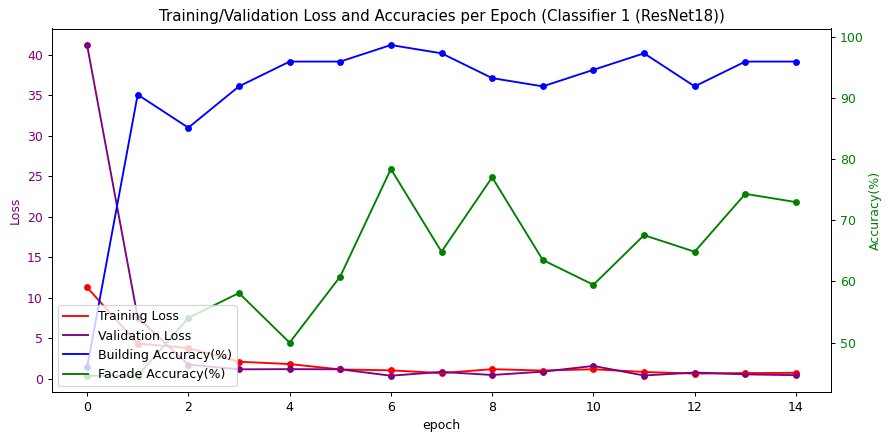

 --Validation Loss: 0.4320  --Building Accuracy: 95.95%  --Facade Accuracy: 72.97%


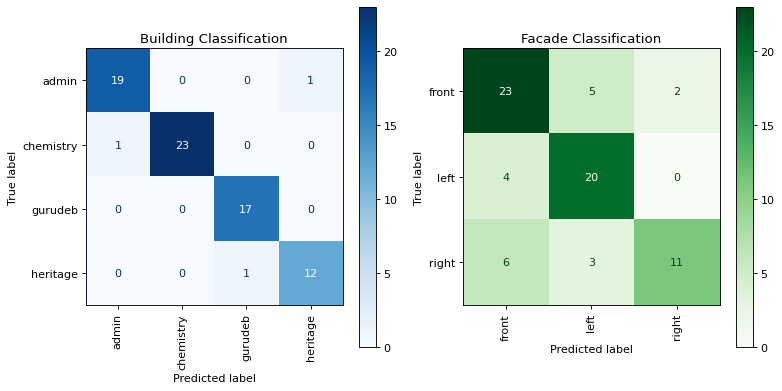

(95.94594594594594, 72.97297297297297, np.float64(0.43197052031755445))

In [19]:
# plot results
plot_classifier_results(result1, 'Classifier 1 (ResNet18)')
classifier1.evaluate(output_logging=True, disp_confusion_matrix=True)

#### Classifier 2

In [20]:
# Instance 2 with different parameters
model1=reset_model(model1) # NEEDED to clear previous run data
classifier2 = BuildingWithFacadeClassifier(
    model=model1,
    optimizer=optim.Adam(model1.parameters(), lr=0.0001),
    batch_size=32,
)

# change output_logging=True to print output of each iteration
# result2 = classifier2.train(n_epochs=10, output_logging=False)
result2 = classifier2.train(n_epochs=10, output_logging=True)

reset all
Starting training with Learning Rate: 0.0001, Batch Size: 32, Epochs: 10, Device: cuda----


 10%|█         | 1/10 [00:12<01:54, 12.69s/it]

 Training loss: 4.8104 --Validation Loss: 1.3949 --Building Accuracy: 90.54% --Facade Accuracy: 62.16%


 20%|██        | 2/10 [00:24<01:38, 12.30s/it]

 Training loss: 1.8122 --Validation Loss: 1.5444 --Building Accuracy: 83.78% --Facade Accuracy: 62.16%


 30%|███       | 3/10 [00:37<01:27, 12.44s/it]

 Training loss: 1.0488 --Validation Loss: 0.7500 --Building Accuracy: 90.54% --Facade Accuracy: 71.62%


 40%|████      | 4/10 [00:50<01:15, 12.64s/it]

 Training loss: 1.3571 --Validation Loss: 0.7447 --Building Accuracy: 90.54% --Facade Accuracy: 81.08%


 50%|█████     | 5/10 [01:03<01:03, 12.77s/it]

 Training loss: 1.2289 --Validation Loss: 0.7698 --Building Accuracy: 91.89% --Facade Accuracy: 75.68%


 60%|██████    | 6/10 [01:16<00:51, 12.81s/it]

 Training loss: 1.1816 --Validation Loss: 1.1980 --Building Accuracy: 91.89% --Facade Accuracy: 81.08%


 70%|███████   | 7/10 [01:28<00:38, 12.81s/it]

 Training loss: 1.3764 --Validation Loss: 0.5879 --Building Accuracy: 91.89% --Facade Accuracy: 86.49%


 80%|████████  | 8/10 [01:41<00:25, 12.86s/it]

 Training loss: 0.8859 --Validation Loss: 0.4580 --Building Accuracy: 93.24% --Facade Accuracy: 83.78%


 90%|█████████ | 9/10 [01:54<00:12, 12.76s/it]

 Training loss: 0.5337 --Validation Loss: 0.6534 --Building Accuracy: 93.24% --Facade Accuracy: 82.43%


100%|██████████| 10/10 [02:07<00:00, 12.71s/it]

 Training loss: 0.5707 --Validation Loss: 0.5270 --Building Accuracy: 93.24% --Facade Accuracy: 82.43%
Training done.....................


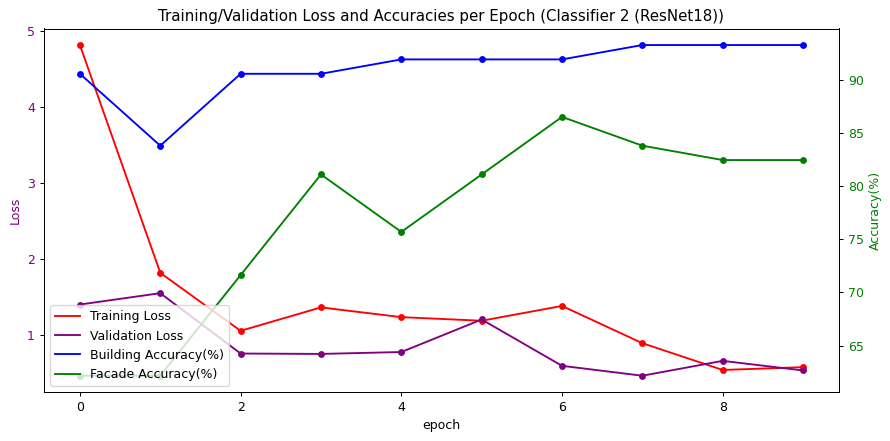

 --Validation Loss: 0.5270  --Building Accuracy: 93.24%  --Facade Accuracy: 82.43%


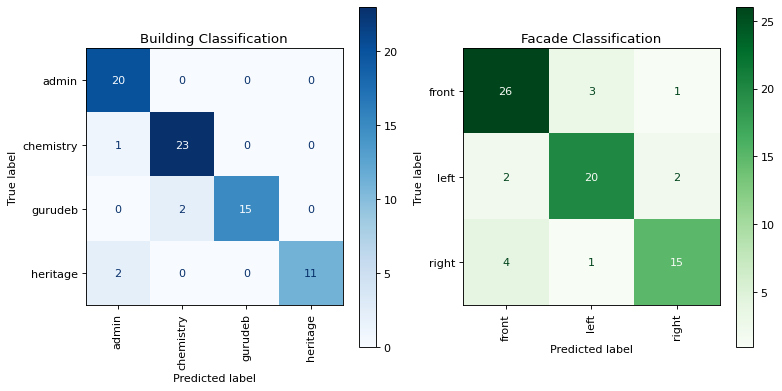

(93.24324324324324, 82.43243243243244, np.float64(0.5269631644090017))

In [21]:
# plot results
plot_classifier_results(result2, 'Classifier 2 (ResNet18)')
classifier2.evaluate(output_logging=True, disp_confusion_matrix=True)

#### Classifier 3

In [38]:
# Instance 3 with different parameters
model1=reset_model(model1) # NEEDED to clear previous run data
classifier3 = BuildingWithFacadeClassifier(
    model=model1,
    optimizer=optim.SGD(model1.parameters(), lr=0.0005, momentum=0.9),
    batch_size=32,
)

# change output_logging=True to print output of each iteration
result3 = classifier3.train(n_epochs=20, output_logging=True)
# result3 = classifier3.train(n_epochs=20, output_logging=True)

reset all
Starting training with Learning Rate: 0.0005, Batch Size: 32, Epochs: 20, Device: cuda----


  5%|▌         | 1/20 [00:15<04:47, 15.12s/it]

 Training loss: 4.5522 --Validation Loss: 1.7278 --Building Accuracy: 72.97% --Facade Accuracy: 41.89%


 10%|█         | 2/20 [00:29<04:20, 14.47s/it]

 Training loss: 1.5917 --Validation Loss: 1.1606 --Building Accuracy: 93.24% --Facade Accuracy: 45.95%


 15%|█▌        | 3/20 [00:42<04:00, 14.16s/it]

 Training loss: 3.0245 --Validation Loss: 1.0010 --Building Accuracy: 82.43% --Facade Accuracy: 51.35%


 20%|██        | 4/20 [00:56<03:43, 13.99s/it]

 Training loss: 1.8284 --Validation Loss: 3.5500 --Building Accuracy: 81.08% --Facade Accuracy: 36.49%


 25%|██▌       | 5/20 [01:10<03:27, 13.84s/it]

 Training loss: 1.9693 --Validation Loss: 0.6271 --Building Accuracy: 93.24% --Facade Accuracy: 56.76%


 30%|███       | 6/20 [01:23<03:13, 13.80s/it]

 Training loss: 1.2113 --Validation Loss: 0.6035 --Building Accuracy: 89.19% --Facade Accuracy: 59.46%


 35%|███▌      | 7/20 [01:38<03:01, 13.95s/it]

 Training loss: 0.9973 --Validation Loss: 0.5509 --Building Accuracy: 94.59% --Facade Accuracy: 66.22%


 40%|████      | 8/20 [01:52<02:46, 13.91s/it]

 Training loss: 2.2771 --Validation Loss: 0.4860 --Building Accuracy: 98.65% --Facade Accuracy: 70.27%


 45%|████▌     | 9/20 [02:05<02:31, 13.77s/it]

 Training loss: 1.2461 --Validation Loss: 0.3918 --Building Accuracy: 98.65% --Facade Accuracy: 66.22%


 50%|█████     | 10/20 [02:19<02:18, 13.80s/it]

 Training loss: 0.7966 --Validation Loss: 0.7055 --Building Accuracy: 97.30% --Facade Accuracy: 63.51%


 55%|█████▌    | 11/20 [02:32<02:03, 13.73s/it]

 Training loss: 1.1301 --Validation Loss: 0.6107 --Building Accuracy: 97.30% --Facade Accuracy: 70.27%


 60%|██████    | 12/20 [02:46<01:49, 13.70s/it]

 Training loss: 0.7008 --Validation Loss: 0.5400 --Building Accuracy: 95.95% --Facade Accuracy: 77.03%


 65%|██████▌   | 13/20 [03:00<01:35, 13.65s/it]

 Training loss: 0.6839 --Validation Loss: 0.5208 --Building Accuracy: 91.89% --Facade Accuracy: 77.03%


 70%|███████   | 14/20 [03:14<01:23, 13.99s/it]

 Training loss: 1.1017 --Validation Loss: 0.5544 --Building Accuracy: 98.65% --Facade Accuracy: 77.03%


 75%|███████▌  | 15/20 [03:29<01:10, 14.06s/it]

 Training loss: 0.6406 --Validation Loss: 0.3621 --Building Accuracy: 97.30% --Facade Accuracy: 79.73%


 80%|████████  | 16/20 [03:42<00:55, 13.87s/it]

 Training loss: 0.8509 --Validation Loss: 0.5047 --Building Accuracy: 98.65% --Facade Accuracy: 74.32%


 85%|████████▌ | 17/20 [03:56<00:41, 13.80s/it]

 Training loss: 0.6565 --Validation Loss: 0.3730 --Building Accuracy: 95.95% --Facade Accuracy: 77.03%


 90%|█████████ | 18/20 [04:10<00:27, 13.84s/it]

 Training loss: 0.4225 --Validation Loss: 0.4966 --Building Accuracy: 97.30% --Facade Accuracy: 75.68%


 95%|█████████▌| 19/20 [04:24<00:14, 14.11s/it]

 Training loss: 0.9037 --Validation Loss: 0.3921 --Building Accuracy: 98.65% --Facade Accuracy: 75.68%


100%|██████████| 20/20 [04:38<00:00, 13.94s/it]

 Training loss: 0.8223 --Validation Loss: 0.4360 --Building Accuracy: 94.59% --Facade Accuracy: 75.68%
Training done.....................


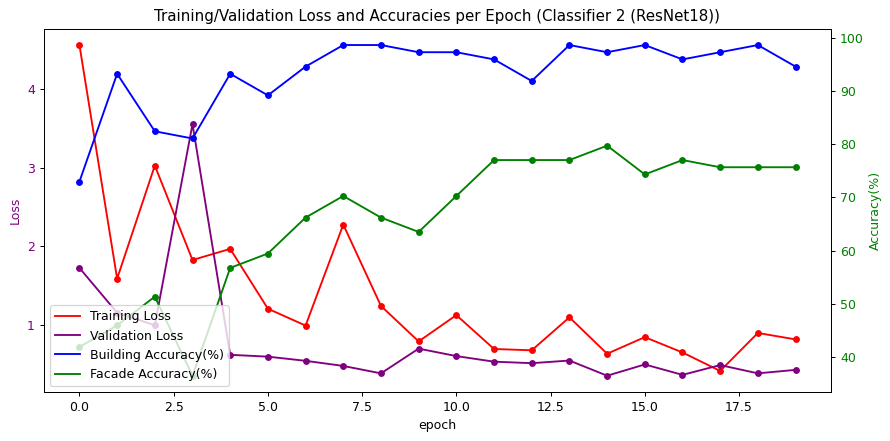

 --Validation Loss: 0.4360  --Building Accuracy: 94.59%  --Facade Accuracy: 75.68%


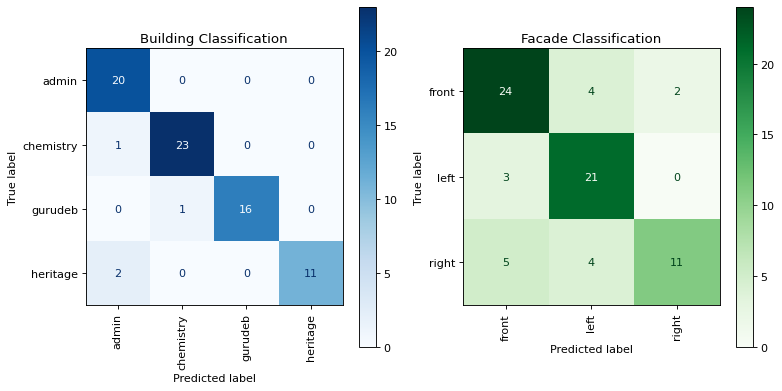

(94.5945945945946, 75.67567567567568, np.float64(0.4360312819480896))

In [39]:
# plot results
plot_classifier_results(result3, 'Classifier 2 (ResNet18)')
classifier3.evaluate(output_logging=True, disp_confusion_matrix=True)

In [40]:
# Instance 3 with different parameters
model1=reset_model(model1) # NEEDED to clear previous run data
classifier32 = BuildingWithFacadeClassifier(
    model=model1,
    optimizer=optim.SGD(model1.parameters(), lr=0.0005, momentum=0.9),
    batch_size=32,
)

# change output_logging=True to print output of each iteration
result32 = classifier32.train(n_epochs=5, output_logging=True)

reset all
Starting training with Learning Rate: 0.0005, Batch Size: 32, Epochs: 5, Device: cuda----


 20%|██        | 1/5 [00:14<00:57, 14.33s/it]

 Training loss: 3.5255 --Validation Loss: 1.0151 --Building Accuracy: 82.43% --Facade Accuracy: 56.76%


 40%|████      | 2/5 [00:29<00:44, 14.72s/it]

 Training loss: 1.4328 --Validation Loss: 1.0563 --Building Accuracy: 95.95% --Facade Accuracy: 66.22%


 60%|██████    | 3/5 [00:49<00:34, 17.19s/it]

 Training loss: 0.8995 --Validation Loss: 0.7301 --Building Accuracy: 98.65% --Facade Accuracy: 75.68%


 80%|████████  | 4/5 [01:07<00:17, 17.46s/it]

 Training loss: 1.5213 --Validation Loss: 0.5353 --Building Accuracy: 91.89% --Facade Accuracy: 66.22%


100%|██████████| 5/5 [01:22<00:00, 16.58s/it]

 Training loss: 2.6652 --Validation Loss: 0.7374 --Building Accuracy: 93.24% --Facade Accuracy: 63.51%
Training done.....................


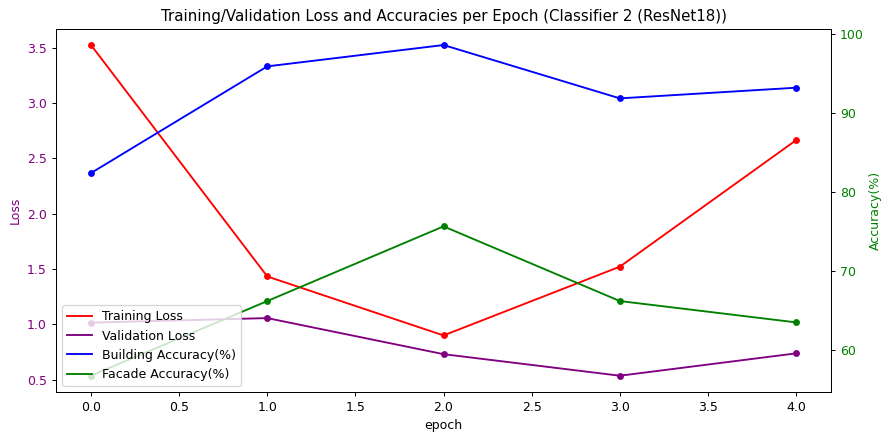

 --Validation Loss: 0.7374  --Building Accuracy: 93.24%  --Facade Accuracy: 63.51%


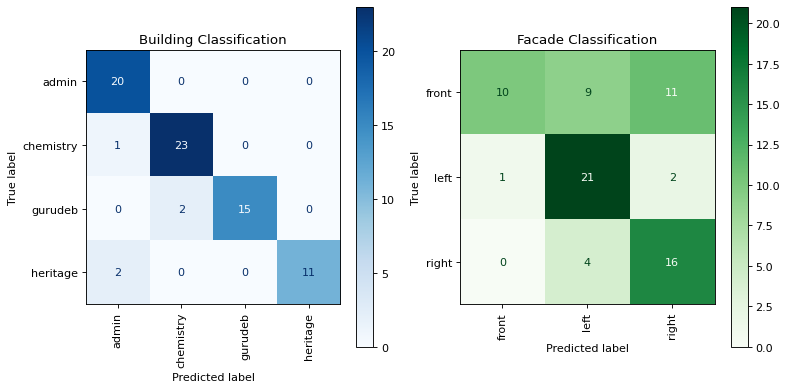

(93.24324324324324, 63.51351351351351, np.float64(0.7374001940091451))

In [41]:
# plot results
plot_classifier_results(result32, 'Classifier 2 (ResNet18)')
classifier32.evaluate(output_logging=True, disp_confusion_matrix=True)

In [24]:
# add more to test

### model 2 ResNet Pretrained=True

In [25]:
model2 = models.resnet18(weights ='ResNet18_Weights.DEFAULT')  # pretrained = True
# Freeze all parameters in the feature extraction layers
# NEEDED when do Pretain with DEFAULT weights
for param in model2.parameters():
    param.requires_grad = False
model2 = modify_last_layer(model2, pretrained=True)
model2._is_pretrained_backbone


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.3MB/s]


last layer output for model = 512 -> 256 -> convert to 4 and 3 outputs


True

#### Classifier 4

In [34]:
# model 2 -> Instance 1 with different parameters
model2=reset_model(model2)
classifier4 = BuildingWithFacadeClassifier(
    model=model2,
    optimizer=optim.Adam(model1.parameters(), lr=0.0001),
    batch_size=16
)

# change output_logging=True to print output of each iteration
# result4 = classifier4.train(n_epochs=20, output_logging=False)
result4 = classifier4.train(n_epochs=20, output_logging=True)



reset last
Starting training with Learning Rate: 0.0001, Batch Size: 16, Epochs: 20, Device: cuda----


  5%|▌         | 1/20 [00:13<04:21, 13.77s/it]

 Training loss: 18.3471 --Validation Loss: 18.8454 --Building Accuracy: 28.38% --Facade Accuracy: 41.89%


 10%|█         | 2/20 [00:27<04:05, 13.66s/it]

 Training loss: 17.7387 --Validation Loss: 19.2938 --Building Accuracy: 24.32% --Facade Accuracy: 41.89%


 15%|█▌        | 3/20 [00:42<04:03, 14.30s/it]

 Training loss: 17.5578 --Validation Loss: 19.4273 --Building Accuracy: 27.03% --Facade Accuracy: 41.89%


 20%|██        | 4/20 [00:56<03:48, 14.28s/it]

 Training loss: 18.1213 --Validation Loss: 18.8030 --Building Accuracy: 25.68% --Facade Accuracy: 41.89%


 25%|██▌       | 5/20 [01:11<03:35, 14.33s/it]

 Training loss: 17.5868 --Validation Loss: 18.4027 --Building Accuracy: 24.32% --Facade Accuracy: 41.89%


 30%|███       | 6/20 [01:24<03:16, 14.03s/it]

 Training loss: 18.2518 --Validation Loss: 18.5279 --Building Accuracy: 27.03% --Facade Accuracy: 41.89%


 35%|███▌      | 7/20 [01:38<03:01, 13.96s/it]

 Training loss: 17.5821 --Validation Loss: 18.5924 --Building Accuracy: 28.38% --Facade Accuracy: 41.89%


 40%|████      | 8/20 [01:52<02:50, 14.18s/it]

 Training loss: 18.2259 --Validation Loss: 18.7740 --Building Accuracy: 25.68% --Facade Accuracy: 41.89%


 45%|████▌     | 9/20 [02:19<03:18, 18.06s/it]

 Training loss: 17.3320 --Validation Loss: 18.9567 --Building Accuracy: 25.68% --Facade Accuracy: 41.89%


 50%|█████     | 10/20 [02:32<02:46, 16.61s/it]

 Training loss: 16.5656 --Validation Loss: 18.7473 --Building Accuracy: 24.32% --Facade Accuracy: 41.89%


 55%|█████▌    | 11/20 [02:46<02:21, 15.71s/it]

 Training loss: 18.0921 --Validation Loss: 18.5778 --Building Accuracy: 24.32% --Facade Accuracy: 41.89%


 60%|██████    | 12/20 [03:00<02:00, 15.05s/it]

 Training loss: 17.7924 --Validation Loss: 19.1239 --Building Accuracy: 25.68% --Facade Accuracy: 41.89%


 65%|██████▌   | 13/20 [03:13<01:41, 14.51s/it]

 Training loss: 17.7023 --Validation Loss: 19.0435 --Building Accuracy: 24.32% --Facade Accuracy: 41.89%


 70%|███████   | 14/20 [03:26<01:25, 14.22s/it]

 Training loss: 17.4908 --Validation Loss: 18.4866 --Building Accuracy: 22.97% --Facade Accuracy: 41.89%


 75%|███████▌  | 15/20 [03:40<01:09, 13.96s/it]

 Training loss: 17.9686 --Validation Loss: 18.9367 --Building Accuracy: 25.68% --Facade Accuracy: 41.89%


 80%|████████  | 16/20 [03:54<00:55, 13.99s/it]

 Training loss: 18.7866 --Validation Loss: 18.4788 --Building Accuracy: 28.38% --Facade Accuracy: 41.89%


 85%|████████▌ | 17/20 [04:08<00:41, 13.91s/it]

 Training loss: 17.5515 --Validation Loss: 18.5713 --Building Accuracy: 24.32% --Facade Accuracy: 41.89%


 90%|█████████ | 18/20 [04:21<00:27, 13.76s/it]

 Training loss: 17.7740 --Validation Loss: 18.8129 --Building Accuracy: 24.32% --Facade Accuracy: 41.89%


 95%|█████████▌| 19/20 [04:34<00:13, 13.61s/it]

 Training loss: 17.6766 --Validation Loss: 19.0451 --Building Accuracy: 24.32% --Facade Accuracy: 41.89%


100%|██████████| 20/20 [04:48<00:00, 14.41s/it]

 Training loss: 17.6691 --Validation Loss: 18.5166 --Building Accuracy: 24.32% --Facade Accuracy: 41.89%
Training done.....................


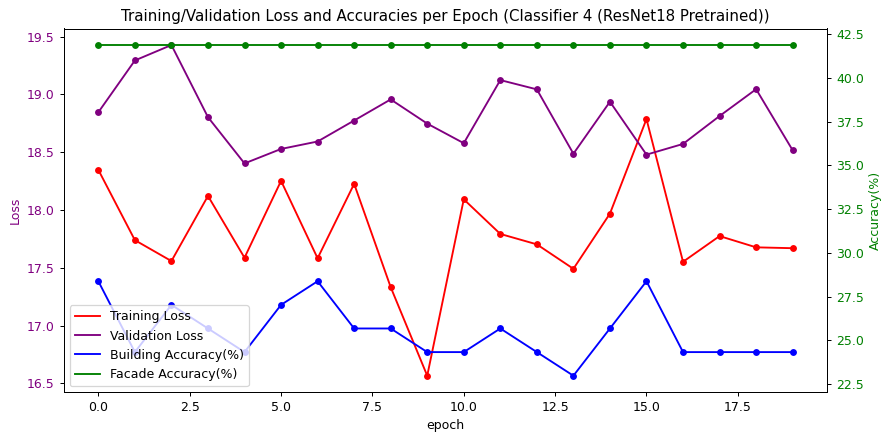

 --Validation Loss: 18.5166  --Building Accuracy: 24.32%  --Facade Accuracy: 41.89%


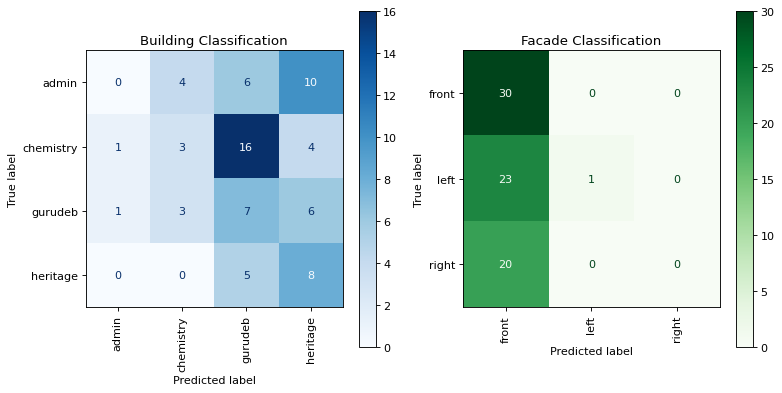

(24.324324324324326, 41.891891891891895, np.float64(18.516632080078125))

In [35]:
# plot results
plot_classifier_results(result4, 'Classifier 4 (ResNet18 Pretrained)')
classifier4.evaluate(output_logging=True, disp_confusion_matrix=True)

#### Classifier 5

In [32]:
# model 2 -> Instance 2 with different parameters
model2=reset_model(model2) # NEEDED for clearing previous run data
classifier5 = BuildingWithFacadeClassifier(
    model=model2,
    optimizer=optim.Adam(model1.parameters(), lr=0.0001),
    batch_size=16
)

# change output_logging=True to print output of each iteration
# result5 = classifier5.train(n_epochs=5, output_logging=False)
result5 = classifier5.train(n_epochs=5, output_logging=True)



reset last
Starting training with Learning Rate: 0.0001, Batch Size: 16, Epochs: 5, Device: cuda----


 20%|██        | 1/5 [00:12<00:51, 12.86s/it]

 Training loss: 24.0455 --Validation Loss: 24.1158 --Building Accuracy: 25.68% --Facade Accuracy: 28.38%


 40%|████      | 2/5 [00:29<00:45, 15.22s/it]

 Training loss: 25.6148 --Validation Loss: 24.6546 --Building Accuracy: 25.68% --Facade Accuracy: 25.68%


 60%|██████    | 3/5 [00:42<00:28, 14.26s/it]

 Training loss: 24.8215 --Validation Loss: 24.7381 --Building Accuracy: 25.68% --Facade Accuracy: 25.68%


 80%|████████  | 4/5 [00:56<00:13, 13.93s/it]

 Training loss: 24.5976 --Validation Loss: 24.3866 --Building Accuracy: 25.68% --Facade Accuracy: 25.68%


100%|██████████| 5/5 [01:09<00:00, 13.94s/it]

 Training loss: 23.7918 --Validation Loss: 24.2163 --Building Accuracy: 25.68% --Facade Accuracy: 28.38%
Training done.....................


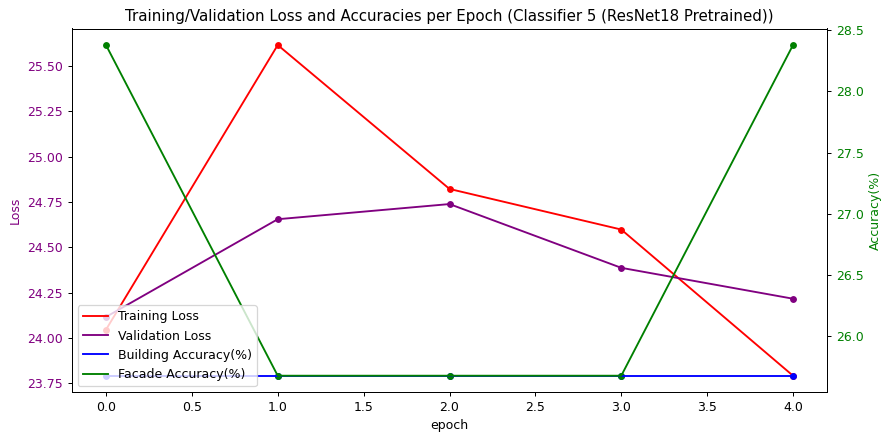

 --Validation Loss: 24.2163  --Building Accuracy: 25.68%  --Facade Accuracy: 28.38%


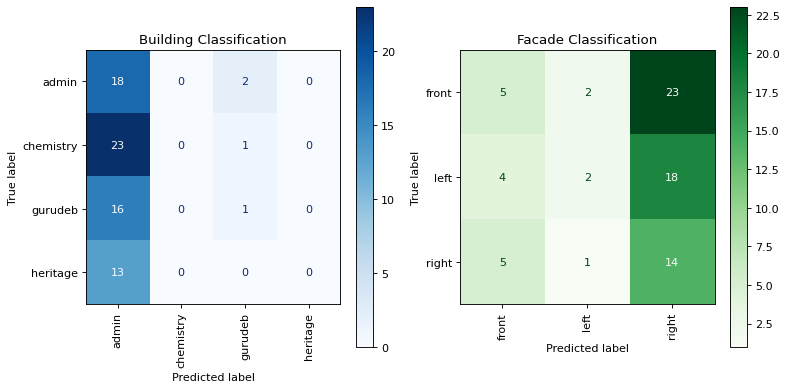

(25.675675675675674, 28.37837837837838, np.float64(24.21630973815918))

In [33]:
# plot results
plot_classifier_results(result5, 'Classifier 5 (ResNet18 Pretrained)')
classifier5.evaluate(output_logging=True, disp_confusion_matrix=True)


In [ ]:
# add more to test